In [340]:
import pandas as pd
import nltk
import pandas as pd
import numpy as np
import mlxtend
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [341]:
#QUESTION 1
#Reading the Csv files
calendar_df = pd.read_csv("/Users/revan/Downloads/calendar.csv")
listings_df = pd.read_csv("/Users/revan/Downloads/listings.csv")
reviews_df = pd.read_csv("/Users/revan/Downloads/reviews.csv")

In [364]:
#Creating a copy of the listings df so that the original df doesn't get modified
numeric_df = listings_df.copy()
#Converting specific columns from object to float
numeric_df['host_response_rate'] = numeric_df['host_response_rate'].str.rstrip("%").astype("float")
numeric_df['host_acceptance_rate'] = numeric_df['host_acceptance_rate'].str.rstrip("%").astype("float") 
for col in ['extra_people','price', 'weekly_price', 'monthly_price']:
    numeric_df[col] = numeric_df[col].replace(r'[\$,]', '', regex=True).astype(float)
#Excluding all object columns and removing certain numerical variables
numeric_df = numeric_df.describe(exclude=['object']).drop(columns=['listing_id','neighbourhood_group_cleansed',
 'scrape_id','latitude', 'longitude','host_id', 'has_availability', 'license', 'jurisdiction_names', 
'review_scores_location', 'calculated_host_listings_count'])

In [365]:
#Creating a new dataframe / table with the descriptive statistics
summary_df = numeric_df.copy()
summary_df.loc['variance'] = numeric_df.var()
#Printing the transpose of the df to create a table
summary_df.T.rename(columns={'50%':'median'})

,count,mean,std,min,25%,median,75%,max,variance
host_response_rate,3114.0,94.989082,1.251769e+01,0.00,97.00,100.00,100.00,100.00,1.158412e+06
host_acceptance_rate,3114.0,84.173089,2.177925e+01,0.00,71.00,94.00,100.00,100.00,1.161707e+06
host_listings_count,3585.0,58.902371,1.711197e+02,0.00,1.00,2.00,7.00,749.00,1.547260e+06
host_total_listings_count,3585.0,58.902371,1.711197e+02,0.00,1.00,2.00,7.00,749.00,1.547260e+06
accommodates,3585.0,3.041283,1.778929e+00,1.00,2.00,2.00,4.00,16.00,1.602736e+06
bathrooms,3571.0,1.221647,5.014871e-01,0.00,1.00,1.00,1.00,6.00,1.592641e+06
bedrooms,3575.0,1.255944,7.530596e-01,0.00,1.00,1.00,2.00,5.00,1.596175e+06
beds,3576.0,1.609060,1.011745e+00,0.00,1.00,1.00,2.00,16.00,1.595612e+06
square_feet,56.0,858.464286,6.088743e+02,0.00,415.00,825.00,1200.00,2400.00,5.860236e+05
price,3585.0,173.925802,1.483313e+02,10.00,85.00,150.00,220.00,4000.00,2.888695e+06


In [344]:
#QUESTION2

#Using the Sentimental_Analysis template provided, a sentiment analysis function is created 
def SentimentalAnalysis(df, text_column):
    sentiment_analysis_columns = ['negativity', 'neutrality', 'positivity', 'compound']
    sid = SentimentIntensityAnalyzer()
    expanded_text_dataset = []
    column_names = list(df.columns.values)
    all_columns = column_names + sentiment_analysis_columns
    text_segment_list = list(df[text_column])
    for j in range(len(text_segment_list)):
        row_info = list(df.iloc[j])
        text = text_segment_list[j]
        ##Sentiment analysis
        try:
            ss = sid.polarity_scores(text)
            negativity = ss['neg']
            neutrality = ss['neu']
            positivity = ss['pos']
            compound = ss['compound']
            temp_data = row_info + [negativity, neutrality, positivity, compound]
            expanded_text_dataset.append(temp_data)
        except:
            #print('Sentiment analysis not done: ' + str(j))
            temp_data = row_info + [None, None, None, None]
            expanded_text_dataset.append(temp_data)
    ##Storing the results in a dataset
    sentiment_dataset_df = pd.DataFrame(expanded_text_dataset, columns = all_columns)
    #sentiment_dataset_df.to_csv('%s_sentiment_analysis.csv' %file_name)
    return sentiment_dataset_df

In [345]:
#Performing Sentimental Analysis on the Reviews. Creating a new dataframe with the sentiment analysis 
sentiment = SentimentalAnalysis(reviews_df, 'comments')
sentiment

,listing_id,id,date,reviewer_id,reviewer_name,comments,negativity,neutrality,positivity,compound
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,0.000,0.648,0.352,0.9626
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,0.000,0.639,0.361,0.9061
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...,0.000,0.767,0.233,0.9663
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...,0.000,0.673,0.327,0.9267
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...,0.000,0.637,0.363,0.8658
...,...,...,...,...,...,...,...,...,...,...
68270,7462268,80537457,2016-06-18,22034145,Antonio,Joe y su mujer son encantadores. La habitación...,0.000,0.946,0.054,0.3400
68271,7462268,83640094,2016-07-03,40052513,Steve,Joe was on his way to Jamaica to be married! o...,0.014,0.822,0.164,0.9504
68272,7462268,85797088,2016-07-13,77129134,Nick,The room was very clean as were the bathrooms ...,0.000,0.784,0.216,0.9693
68273,7462268,97264637,2016-08-26,15799803,Vid,Staying in Lower Allston at Joe and Nancy's pl...,0.014,0.759,0.226,0.9957


In [346]:
def SentimentalAnalysis_v2(df, text_column):
    sentiment_analysis_columns = ['positivity_simple', 'negativity_simple']
    positive_words = pd.read_csv("/Users/revan/Downloads/positive_words.csv", header=None, names=['Words']) #Reading the csv files that have positive and negative words
    negative_words = pd.read_csv("/Users/revan/Downloads/negative_words.csv", encoding='ISO-8859-1', header=None, names=['Words'])    
    positive_set = set(positive_words['Words'])
    negative_set = set(negative_words['Words'])
    expanded_text_dataset = []
    column_names = list(df.columns.values)
    all_columns = column_names + sentiment_analysis_columns
    text_segment_list = list(df[text_column])
    for j in range(len(text_segment_list)):
        row_info = list(df.iloc[j])
        text = text_segment_list[j]
        words = str(text).split()                          
        ##Sentiment analysis
        try:            
            pos = [word for word in words if word in positive_set]
            neg = [word for word in words if word in negative_set]
            positive_simple = len(pos) / len(words)
            negative_simple = len(neg) / len(words)
            temp_data = row_info + [positive_simple, negative_simple]
            expanded_text_dataset.append(temp_data)
        except:
            temp_data = row_info + [None, None]
            expanded_text_dataset.append(temp_data)
    ##Storing the results in a dataset
    sentiment_dataset_df = pd.DataFrame(expanded_text_dataset, columns = all_columns)
    #sentiment_dataset_df.to_csv('%s_sentiment_analysis.csv' %file_name)
    return sentiment_dataset_df

In [347]:
#Performing Sentimental Analysis on the Reviews. Creating a new datafrae with the sentiment analysis
sentiment_v2 = SentimentalAnalysis_v2(sentiment, 'comments')
sentiment_v2.head(10)

Sentiment analysis not done: 20327


In [349]:
#QUESTION3
#Getting the mean of the scores and matching the listing_ids. A new dataframe is created for organization purposes
reviews_scores =  ['negativity', 'neutrality', 'positivity', 'compound','positivity_simple', 'negativity_simple']
mean_df = sentiment_v2[['listing_id'] + reviews_scores].groupby('listing_id').mean()
#Adding the mean columns
mean_df.rename(columns=lambda col:  col+'_mean', inplace=True)
mean_df = mean_df.reset_index() #Converted the Ids to index
mean_df.head(10)

,listing_id,negativity_mean,neutrality_mean,positivity_mean,compound_mean,positivity_simple_mean,negativity_simple_mean
0,3353,0.025971,0.706206,0.267735,0.782121,0.071044,0.008075
1,5506,0.011583,0.715806,0.272639,0.874283,0.076015,0.002254
2,6695,0.017468,0.731851,0.250638,0.857415,0.069903,0.006497
3,6976,0.010854,0.724488,0.264659,0.905349,0.078709,0.001326
4,8792,0.015722,0.690056,0.294278,0.931694,0.081664,0.004809
5,9273,0.017077,0.765769,0.217154,0.864423,0.077203,0.004205
6,9765,0.037889,0.731778,0.230222,0.732167,0.046888,0.009969
7,9824,0.033682,0.698091,0.268273,0.828700,0.059202,0.014752
8,9855,0.005333,0.710333,0.284667,0.954200,0.053862,0.000000
9,9857,0.018190,0.649905,0.331905,0.866000,0.073658,0.005236


In [350]:
#merged the listings and mean dfs together
merged_df = listings_df.merge(mean_df, on='listing_id')
merged_df.head(10)

,listing_id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,negativity_mean,neutrality_mean,positivity_mean,compound_mean,positivity_simple_mean,negativity_simple_mean
0,3075044,https://www.airbnb.com/rooms/3075044,2.020000e+13,9/7/16,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,f,f,1,1.30,0.014000,0.664056,0.321944,0.837644,0.085016,0.005188
1,6976,https://www.airbnb.com/rooms/6976,2.020000e+13,9/7/16,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,t,f,1,0.47,0.010854,0.724488,0.264659,0.905349,0.078709,0.001326
2,1436513,https://www.airbnb.com/rooms/1436513,2.020000e+13,9/7/16,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,f,f,1,1.00,0.000000,0.516000,0.484000,0.950600,0.041667,0.000000
3,7651065,https://www.airbnb.com/rooms/7651065,2.020000e+13,9/7/16,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,f,f,1,2.25,0.017034,0.709069,0.273897,0.780959,0.084973,0.003509
4,12386020,https://www.airbnb.com/rooms/12386020,2.020000e+13,9/7/16,Private Bedroom + Great Coffee,Super comfy bedroom plus your own bathroom in ...,Our sunny condo is located on the second and t...,Super comfy bedroom plus your own bathroom in ...,none,We love our corner of Roslindale! For quiet wa...,...,f,f,1,1.70,0.007750,0.756125,0.236125,0.824700,0.066098,0.000000
5,5706985,https://www.airbnb.com/rooms/5706985,2.020000e+13,9/7/16,New Lrg Studio apt 15 min to Boston,It's a 5 minute walk to Rosi Square to catch t...,The whole house was recently redone and it 's ...,It's a 5 minute walk to Rosi Square to catch t...,none,Roslindale is the new hip area of Boston. Clos...,...,f,f,3,4.00,0.013614,0.698895,0.287474,0.796619,0.073931,0.006256
6,2843445,https://www.airbnb.com/rooms/2843445,2.020000e+13,9/7/16,"""Tranquility"" on ""Top of the Hill""","We can accommodate guests who are gluten-free,...",We provide a bedroom and full shared bath. Ra...,"We can accommodate guests who are gluten-free,...",none,Our neighborhood is residential with friendly ...,...,t,t,2,2.38,0.005060,0.661731,0.333179,0.943557,0.086703,0.001783
7,753446,https://www.airbnb.com/rooms/753446,2.020000e+13,9/7/16,6 miles away from downtown Boston!,Nice and cozy apartment about 6 miles away to ...,Nice and cozy apartment about 6 miles away to ...,Nice and cozy apartment about 6 miles away to ...,none,Roslindale is a primarily residential neighbor...,...,f,f,1,5.36,0.008708,0.687708,0.303585,0.817729,0.080302,0.002177
8,849408,https://www.airbnb.com/rooms/849408,2.020000e+13,9/7/16,Perfect & Practical Boston Rental,This is a cozy and spacious two bedroom unit w...,Perfect apartment rental for those in town vis...,This is a cozy and spacious two bedroom unit w...,none,"This neighborhood truly has it all. Good, not...",...,f,f,2,1.01,0.020212,0.691727,0.288091,0.916958,0.073443,0.008940
9,12023024,https://www.airbnb.com/rooms/12023024,2.020000e+13,9/7/16,Cozy room in a well located house,The room is in a single family house located i...,NaN,The room is in a single family house located i...,none,NaN,...,f,f,1,0.36,0.000000,0.697000,0.303000,0.96330

In [367]:
#QUESTION4
#Creating a 
rooms = listings_df[['property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms']]
rooms = rooms.dropna()
rooms = rooms.astype(str)
val = pd.get_dummies(rooms)

#Results were reported in the results part of the report
apriori(val, min_support=0.1, use_colnames=True)

/Users/revan/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.729342,(property_type_Apartment)
1,0.156549,(property_type_House)
2,0.593311,(room_type_Entire home/apt)
3,0.384486,(room_type_Private room)
4,0.121979,(accommodates_1)
...,...,...
65,0.137437,"(property_type_Apartment, room_type_Private ro..."
66,0.195616,"(property_type_Apartment, bathrooms_1.0, room_..."
67,0.217819,"(property_type_Apartment, bathrooms_1.0, bedro..."
68,0.192243,"(bathrooms_1.0, room_type_Private room, bedroo..."


In [352]:
#Finding both the most and least frequent items using apriori with a new min_support value
apriori(val, min_support=0.2, use_colnames=True)

/Users/revan/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.729342,(property_type_Apartment)
1,0.593311,(room_type_Entire home/apt)
2,0.384486,(room_type_Private room)
3,0.411748,(accommodates_2)
4,0.769533,(bathrooms_1.0)
5,0.664418,(bedrooms_1.0)
6,0.491849,"(property_type_Apartment, room_type_Entire hom..."
7,0.220349,"(property_type_Apartment, room_type_Private room)"
8,0.290051,"(property_type_Apartment, accommodates_2)"
9,0.599494,"(property_type_Apartment, bathrooms_1.0)"


In [353]:
#Question 5
#Making Apriori algorithm from scratch
def possible_sets(cols):
    if len(cols) == 0:
            return [[]]
    cs = []
    for c in possible_sets(cols[1:]):
        cs += [c, c + [cols[0]]]
    return cs


def frequency_count(df):
    df  = df.astype(str)
    for col in df.columns:
        df[col] = col + "_" + df[col]
    counts = {}
    item_sets = possible_sets(df.columns)
    for xcol in item_sets[1:]:
        for ix,row in df[xcol].iterrows():
            key = tuple(row.values)
            if key not in counts:
                counts[key] = 1
            else:
                counts[key] += 1
    return counts

def apriori_simple(df, min_support=0.1):
    counts = frequency_count(df)
    c_df = pd.DataFrame({'itemsets': counts.keys(),
                         'count': counts.values()})
    c_df['support'] = c_df['count']/df.shape[0]
    c_df = c_df[c_df['support'] > min_support]
    return c_df[['support', 'itemsets']].sort_values('support', ascending=False).copy()

apriori_simple(rooms)

,support,itemsets
264,0.769533,"(bathrooms_1.0,)"
1,0.729342,"(property_type_Apartment,)"
1072,0.664418,"(bedrooms_1.0,)"
276,0.599494,"(bathrooms_1.0, property_type_Apartment)"
13,0.593311,"(room_type_Entire home/apt,)"
...,...,...
1384,0.102586,"(bedrooms_1.0, accommodates_1, room_type_Priva..."
135,0.102586,"(accommodates_1, room_type_Private room)"
334,0.102024,"(bathrooms_2.0, room_type_Entire home/apt)"
1627,0.101180,"(bedrooms_2.0, bathrooms_1.0)"


In [354]:
#Question 6
#Using Linear Regression to predict Price (Y) column

x_col = ['host_response_rate', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness'
              , 'review_scores_checkin', 'review_scores_communication', 'positivity_mean', 'negativity_mean'
              ,'negativity_simple_mean', 'positivity_simple_mean']
price_df = merged_df[x_col + ['price']].copy()
price_df['host_response_rate'] = price_df['host_response_rate'].str.rstrip("%").astype("float") / 100
price_df['price'] = price_df['price'].replace(r'[\$,]', '', regex=True).astype(float)
price_df.dropna(inplace=True)


x = price_df[x_col].values
y = price_df[['price']].values


sm_model = sm.OLS(y, x)
results = sm_model.fit()
print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.706
Model:                            OLS   Adj. R-squared (uncentered):              0.705
Method:                 Least Squares   F-statistic:                              607.3
Date:                Sat, 15 Oct 2022   Prob (F-statistic):                        0.00
Time:                        19:25:39   Log-Likelihood:                         -15534.
No. Observations:                2543   AIC:                                  3.109e+04
Df Residuals:                    2533   BIC:                                  3.115e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [355]:
#QUESTION7


scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
y_scaled = scaler.fit_transform(y)

pca = PCA(n_components = 3)

x_pca = pca.fit_transform(x_scaled)

#print(x_pca.shape, y_scaled.shape)

#model2 = LinearRegression().fit(x_pca,y_scaled)
#Y_new = model2.predict(x_pca) 
#print(f"slope: {model2.coef_}")

#r_sq2 = model2.score(x_pca, y_scaled)
#print(f"r-squared: {r_sq2}")

sm_model2 = sm.OLS(y_scaled, x_pca)
results2 = sm_model2.fit()
print(results2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              2.837
Date:                Sat, 15 Oct 2022   Prob (F-statistic):                      0.0368
Time:                        19:25:42   Log-Likelihood:                         -3604.1
No. Observations:                2543   AIC:                                      7214.
Df Residuals:                    2540   BIC:                                      7232.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

0.9664192294096854 0.008837044892188053 0.024743725698126547


array([<AxesSubplot:ylabel='x'>], dtype=object)

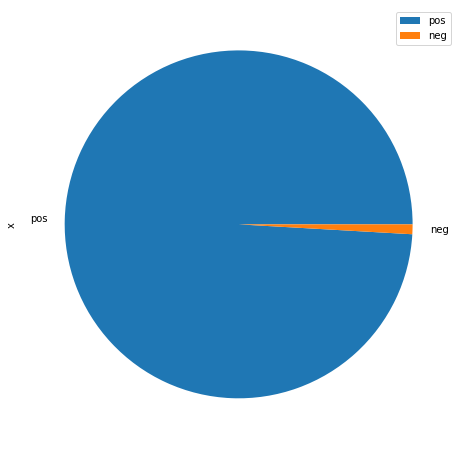

In [368]:
#QUESTION8

neg = len(merged_df[merged_df['compound_mean'] < 0]) / len(merged_df)
zero = len(merged_df[merged_df['compound_mean'] == 0]) / len(merged_df)
pos = len(merged_df[merged_df['compound_mean'] > 0]) / len(merged_df)

#print(pos+neg+zero)

print(pos, neg, zero)
compound_df = pd.DataFrame([pos, neg], index=['pos', 'neg'], columns=['x'])
compound_df.plot(kind='pie', subplots=True, figsize=(8, 8))


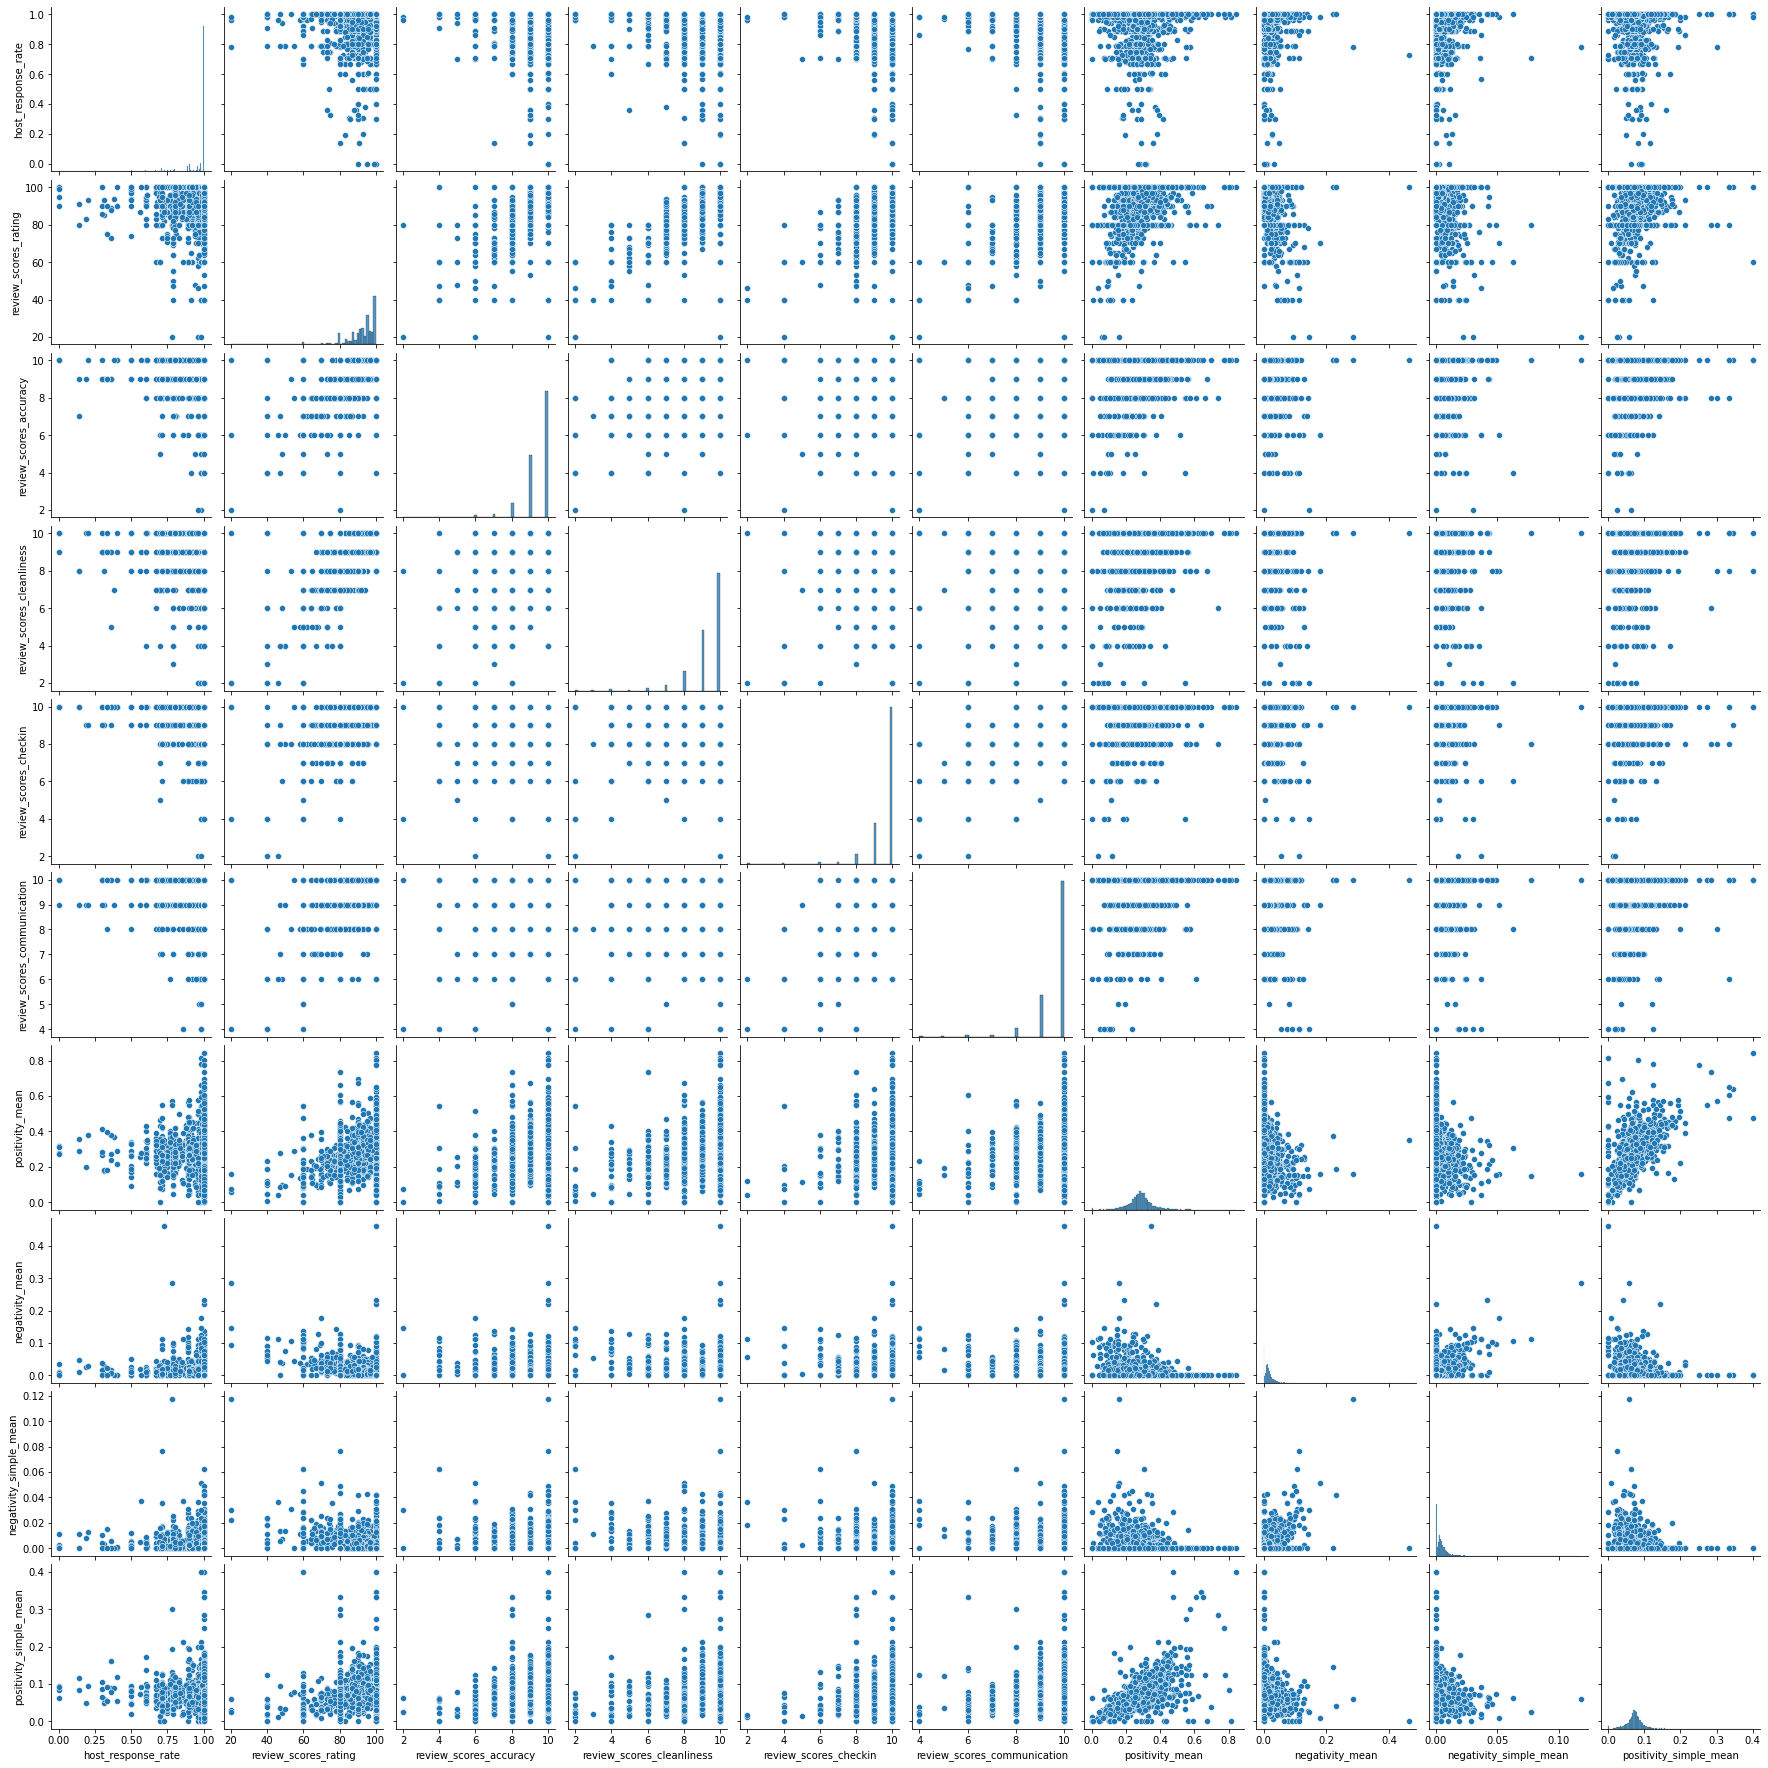

In [357]:
sns.pairplot(price_df[x_col], kind='scatter')
plt.show()

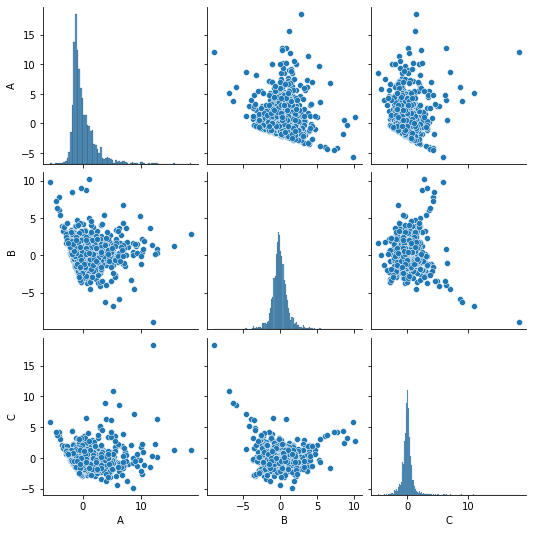

In [248]:
sns.pairplot(pd.DataFrame(x_pca, columns=['A','B','C']))